### Solutions of PS2

This notebook is in html. To be able to run it, please click: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gunerilhan/economicgrowth/blob/master/ps2/ps2.ipynb)

In [1]:
# First import the packages we'll need
# Numpy is for numerical analysis
import numpy as np
# Pandas is for data storage and manipulation
import pandas as pd
# Matplotlib and seaborn are for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import style
style.use('https://gunerilhan.github.io/img/fivethirtyeight-modified.mplstyle')

In [2]:
# Different color palettes that can be used in plots
colors = {0:['#264653','#219D8F','#E9C46A','#F4A261','#E76F51'],
  1:['#003049','#D62828','#F77F00','#FCBF49','#EAE2B7'],
  2:['#F72585','#7209B7','#3A0CA3','#4361EE','#4CC9F0'],
  3: ['#165aa7','#cb495c','#bb60d5','#f47915','#06ab54','#002070','#b27d12','#007030']}

In this problem set, you will do a different growth exercise, in which you will decompose the growth rate of output per _capita_ into productivity growth, capital deepening (growth in physical capital to output ratio), human capital growth, and growth in total hours worked to population ratio. Let's start with a Cobb-Douglas production function: $Y = A K^\alpha (hL)^{1-\alpha},$ where $L$ is the **total hours worked in the economy** and other $Y,A,K,h$ are as defined in the lectures. We will do some algebra to write output per capita as a function of productivity, capital-output ratio, human capital, and total hours worked to population ratio. 

- Divide the both sides of the production function, $Y = A K^\alpha (hL)^{1-\alpha},$ by $Y^{\alpha}$: $$\frac{Y}{Y^\alpha}= Y^{1-\alpha}= A \left(\frac{K}{Y}\right)^\alpha (hL)^{1-\alpha}$$

- Raise both sides to the power of $1/(1-\alpha)$: $Y= A^{1/(1-\alpha)} \left(\frac{K}{Y}\right)^{\alpha/(1-\alpha)} hL$

- Divide both sides with population, $N$:  $\frac{Y}{N}= A^{1/(1-\alpha)} \left(\frac{K}{Y}\right)^{\alpha/(1-\alpha)} h\frac{L}{N}$

- Taking the natural log of the above equation and differentiating with respect to time yields:

$$g_{\frac{Y}{N}}= \frac{1}{1-\alpha}g_A+\frac{\alpha}{1-\alpha}g_{\frac{K}{Y}} + g_h + g_{\frac{L}{N}}$$

- Re-arranging the above formula yields the productivity growth rate:


$$g_A = (1-\alpha) \left[g_{\frac{Y}{N}}-\frac{\alpha}{1-\alpha}g_{\frac{K}{Y}} - g_h - g_{\frac{L}{N}} \right]$$

In questions 2 and 3, using  Penn World Table, https://www.rug.nl/ggdc/productivity/pwt/, you will do growth accounting. Assume $\alpha=1/3$ for questions 0 and 1.

In [3]:
# Here, I download the Penn World Tables legend
df_legend = pd.read_excel('https://dataverse.nl/api/access/datafile/354095',sheet_name='Legend')
df_legend.dropna(subset=['Variable name','Variable definition'],inplace=True)
# I create a dictionary of variable names and definitions
df_legend = dict(zip(df_legend['Variable name'],df_legend['Variable definition']))

In [4]:
# Here are the variables, we will need in this analysis
print('rgdpna = ', df_legend['rgdpna'])
print('rkna = ', df_legend['rkna'])
print('emp = ', df_legend['emp'])
print('avh = ', df_legend['avh'])
print('pop = ', df_legend['pop'])
print('hc =', df_legend['hc'])

rgdpna =  Real GDP at constant 2017 national prices (in mil. 2017US$)
rkna =  Capital services at constant 2017 national prices (2017=1)
emp =  Number of persons engaged (in millions)
avh =  Average annual hours worked by persons engaged
pop =  Population (in millions)
hc = Human capital index, based on years of schooling and returns to education; see Human capital in PWT9.


In [5]:
# now download the data
df = pd.read_excel('https://dataverse.nl/api/access/datafile/354095',sheet_name='Data')

In [6]:
# create GDP per capita 
df['gdppc'] = df['rgdpna']/df['pop']
# create physical capital / output ratio 
df['cap-output'] = df['rkna']/df['rgdpna']
# create total labor hours / population ratio
df['epop'] = df['emp']*df['avh']/df['pop']

In [7]:
# Create a dictionary of countrynames: inputting a country code yields the country name
country_names=dict(zip(df[df.year==2018]['countrycode'],df[df.year==2018]['country']))
# a minor adjustment in the country names
country_names['GBR'] = 'the United Kingdom'
country_names['USA'] = 'the United States'

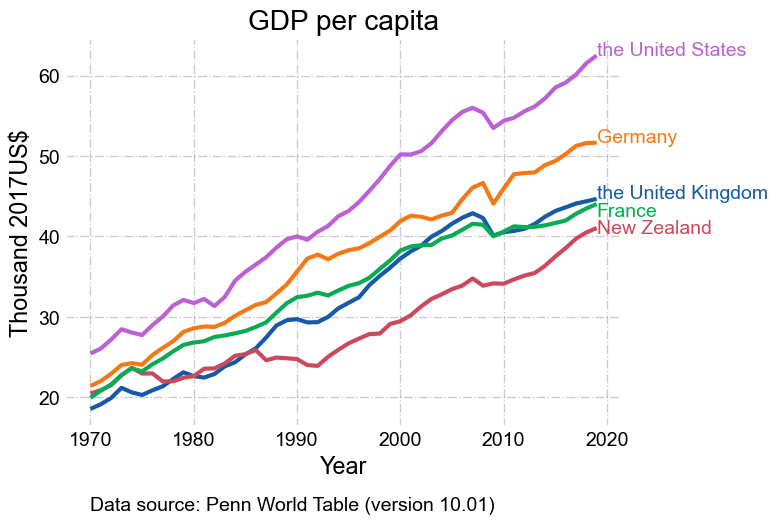

In [8]:
# To start, let's plot GDP per capita of our countries of interest
country_list = ['GBR','NZL','USA','DEU','FRA']
for country in country_list:
    # select our country
    data = df[(df.countrycode==country)&(df.year>=1970)].copy()
    # express GDP pc in thousand USDs
    data['gdppc'] *= 1/1000
    country_ = country_names[country] # get the country name
    p=plt.plot(data.year,data.gdppc) # plot
    # to annotate the graph, I get the last year and GDP pc in the last year
    # then I write the country name on this location
    loc_ = data.iloc[-1][['year','gdppc']].values
    # these are minor adjustments to locations 
    if country in ['FRA','JPN']:
        loc_[1] += -1.5
    elif country == 'NZL':
        loc_[1] += -0.7    
    plt.annotate(country_,loc_,color=p[0].get_color())
plt.xlabel('Year')
plt.ylabel('Thousand 2017US$');
plt.title('GDP per capita');
plt.text(1970,6,'Data source: Penn World Table (version 10.01)');
#plt.savefig('./gpdpc.png',bbox_inches='tight',dpi=300)

In [9]:
# Write down the function to find the productivity growth
# x is the input with growth rate of the required variables
alpha = 1/3
prod_growth = lambda x: (x['gdppc']-(alpha/(1-alpha))*x['cap-output']
                              -x['hc']-x['epop'])*(1-alpha)

In [10]:
# a function to find the growth rate of the required vars.
# group is the input data containing information about 
# the variables in different years
# vars_: set of variables whose growth rate will be calculated
# years_: the years on which the growth rates will be calculated
# prod_growth is the function to be used to calculate the growth rate
# we will use the log difference method to calculate the growth rate
# another way of calculating the average growth rate is coded in 
# the else part of the if else statement.
def growth_rates(group,vars_,years_,prod_growth,algo='ln'):
    group.sort_values('year',inplace=True)
    data = group[group.year.isin(years_)][['country']+vars_].copy()
    if algo == 'ln':
        data[vars_] = data[vars_].apply(np.log).diff(periods=1,axis=0)/(years_[1]-years_[0])
    else:
        init_years = data.iloc[0][vars_].values
        late_years = data.iloc[1][vars_].values
        index_ = data.index
        data.loc[index_[0],vars_] = np.nan
        data.loc[index_[1],vars_] = (late_years/init_years)**(1/(years_[1]-years_[0]))-1
    data['Period'] = f"{years_[0]}-{years_[1]}"
    data['Productivity'] = prod_growth(data)
    data[vars_+['Productivity']] *= 100
    return data.iloc[1]
        

In [11]:
# We will need to calculate the growth rate of these vars, which then will 
# be used to calculate the growth rate of the productivity
vars_ = ['gdppc','cap-output','hc','epop']

In [12]:
# by calling the growth_rates function for each country and for each time period
# calculate average growth rates and append them into a data frame
df_growth = pd.DataFrame()
for years_ in [[1970,2008],[2009,2019]]:
    df_growth=pd.concat([df_growth,(df.groupby('countrycode').apply(
        lambda x: growth_rates(x,vars_,years_,prod_growth)))])

In [13]:
# These are the list of countries we will analyze
country_list_1  = ['GBR','NZL','USA','DEU','FRA']

In [14]:
# Here are the growth rates
df_growth.loc[country_list_1].round(decimals=2)

,country,gdppc,cap-output,hc,epop,Period,Productivity
countrycode,,,,,,,
GBR,United Kingdom,2.17,0.65,0.76,-0.13,1970-2008,0.80
GBR,United Kingdom,1.08,0.08,0.24,0.65,2009-2019,0.10
NZL,New Zealand,1.32,1.61,0.13,0.27,1970-2008,0.08
NZL,New Zealand,1.84,0.54,0.57,0.62,2009-2019,0.25
USA,United States,2.05,0.52,0.48,0.28,1970-2008,0.68
USA,United States,1.56,-0.28,0.17,0.64,2009-2019,0.60
DEU,Germany,2.05,1.14,0.58,-0.75,1970-2008,1.09
DEU,Germany,1.59,-0.38,0.08,0.57,2009-2019,0.75
FRA,France,1.93,1.00,0.71,-0.60,1970-2008,0.88


In [15]:
# I convert the above table, in the wide form, to long form

# Select the variables of interest and the countries of interest
df_growth_1 = df_growth[['country','Period']+vars_+['Productivity']].loc[country_list_1]

# Rename variables 
df_growth_1.columns= ['Country','Period','GDPpc','Capital deepening','Human Capital','E/pop','Productivity']

# Convert into long form
df_growth_1=df_growth_1.reset_index().melt(id_vars=['countrycode','Country','Period'],
                               value_vars=['GDPpc','Capital deepening','Human Capital','E/pop','Productivity'],
                              value_name='Growth rate',var_name='Factor').set_index('countrycode')

In [16]:
df_growth_1.round(decimals=2)

,Country,Period,Factor,Growth rate
countrycode,,,,
GBR,United Kingdom,1970-2008,GDPpc,2.17
GBR,United Kingdom,2009-2019,GDPpc,1.08
NZL,New Zealand,1970-2008,GDPpc,1.32
NZL,New Zealand,2009-2019,GDPpc,1.84
USA,United States,1970-2008,GDPpc,2.05
USA,United States,2009-2019,GDPpc,1.56
DEU,Germany,1970-2008,GDPpc,2.05
DEU,Germany,2009-2019,GDPpc,1.59
FRA,France,1970-2008,GDPpc,1.93


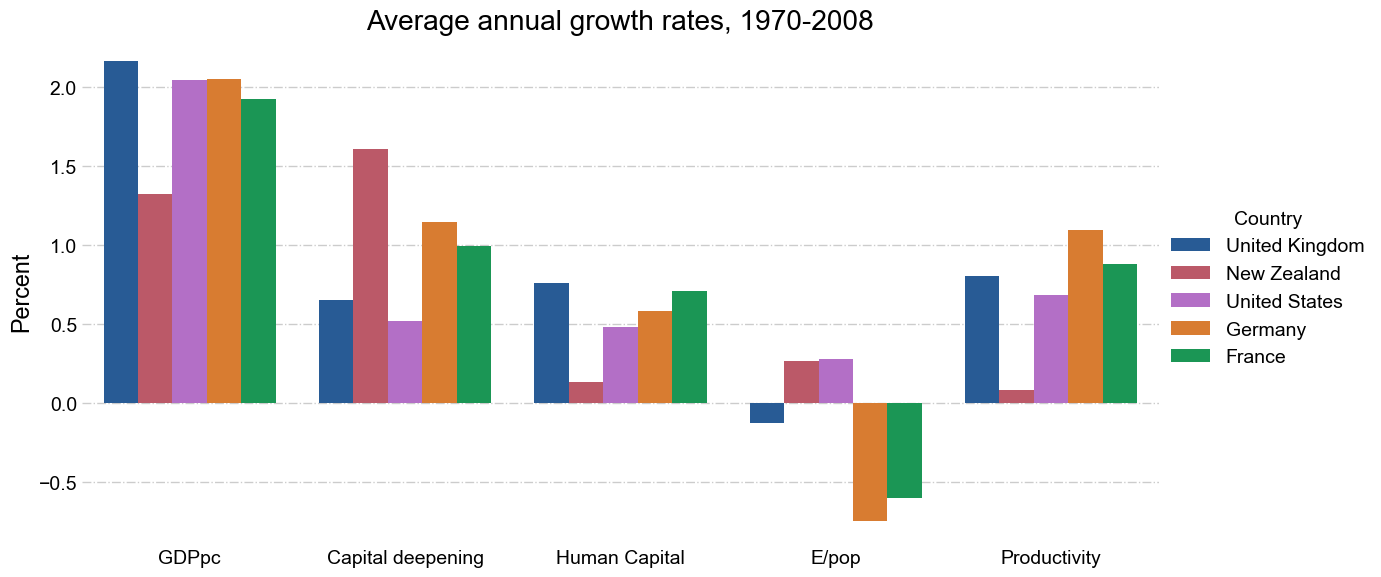

In [17]:
# plot the data
g = sns.catplot(hue='Country', y="Growth rate", x="Factor", 
                data=df_growth_1[df_growth_1.Period=='1970-2008'].loc[country_list_1],
                height=6, aspect=2,kind="bar")
g.despine(left=True,bottom=True)
g.set_ylabels("Percent")
g.set_xlabels("")
plt.title('Average annual growth rates, 1970-2008');

We observe from the above graph that, physical capital per output and productivity grow at faster rates than labor hours to population ratio (by slightly abusing the terminology, I call it e/pop: employment to populatio ratio, but it is labor hours to population ratio) in most countries from 1970 to 2019.

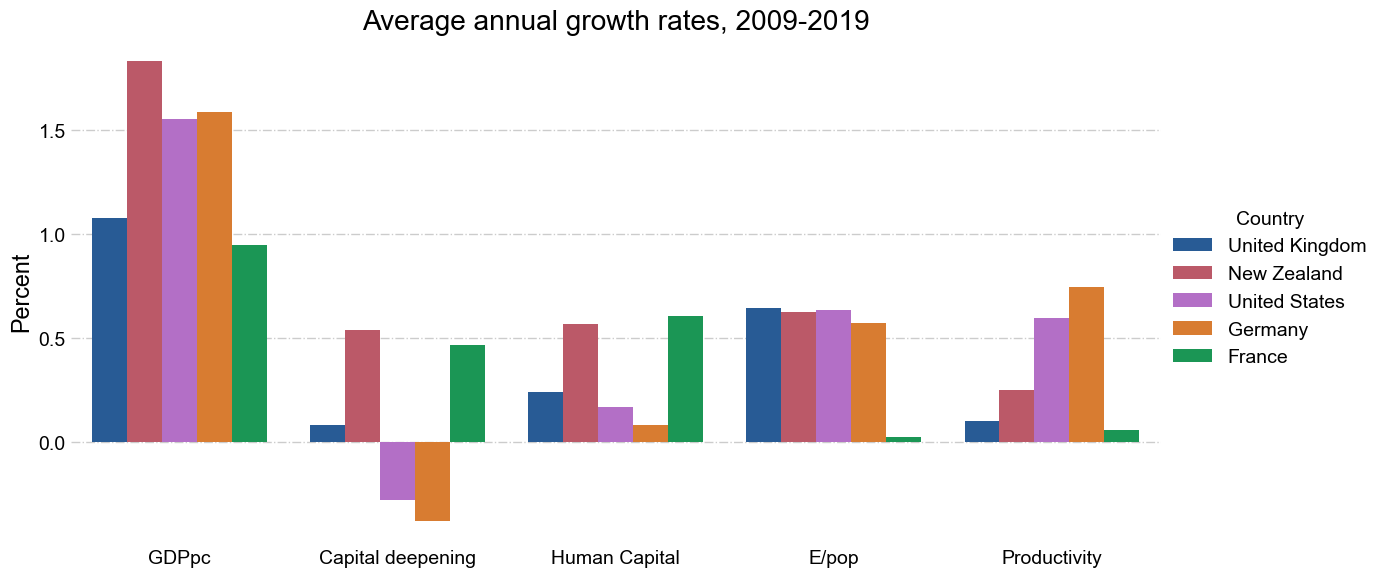

In [18]:
# plot the data
g = sns.catplot(hue='Country', y="Growth rate", x="Factor", 
                data=df_growth_1[df_growth_1.Period=='2009-2019'].loc[country_list_1],
                height=6, aspect=2,kind="bar")
g.despine(left=True,bottom=True)
g.set_ylabels("Percent")
g.set_xlabels("")
plt.title('Average annual growth rates, 2009-2019');

During 2009-2019, we observe that labr hours to population ratio grew faster than productivity and physical capital to output ratio in most countries.

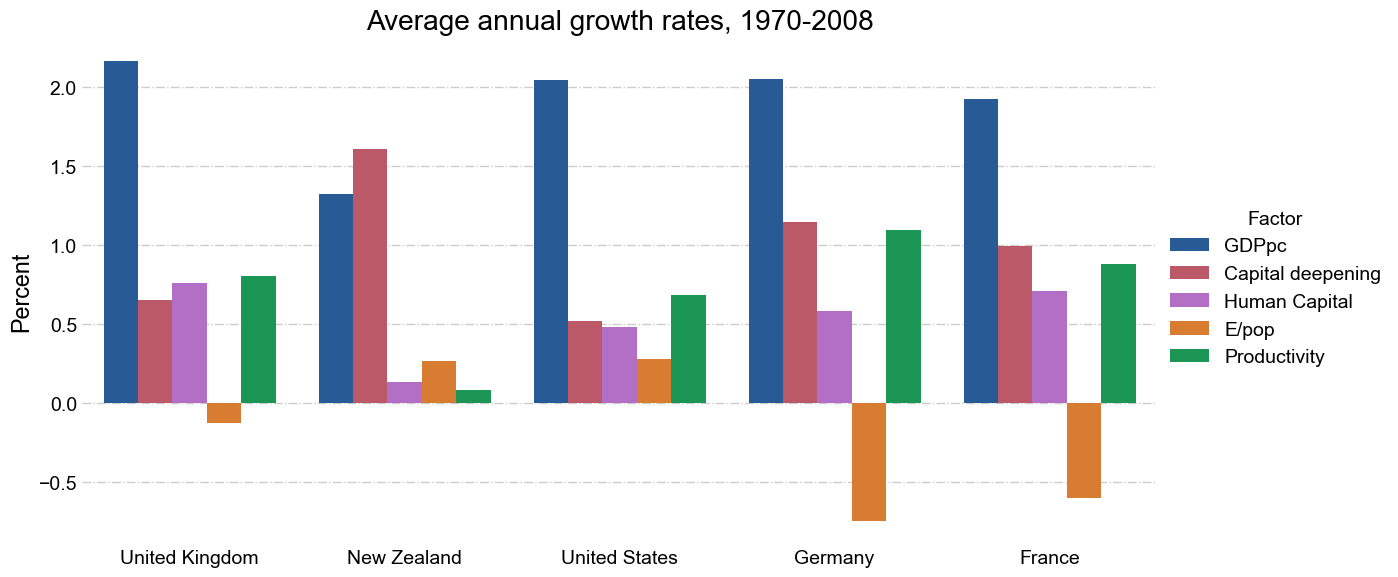

In [19]:
# plot the data
g = sns.catplot(x='Country', y="Growth rate", hue="Factor", 
                data=df_growth_1[df_growth_1.Period=='1970-2008'].loc[country_list_1],
                height=6, aspect=2,kind="bar")
g.despine(left=True,bottom=True)
g.set_ylabels("Percent")
g.set_xlabels("")
plt.title('Average annual growth rates, 1970-2008');

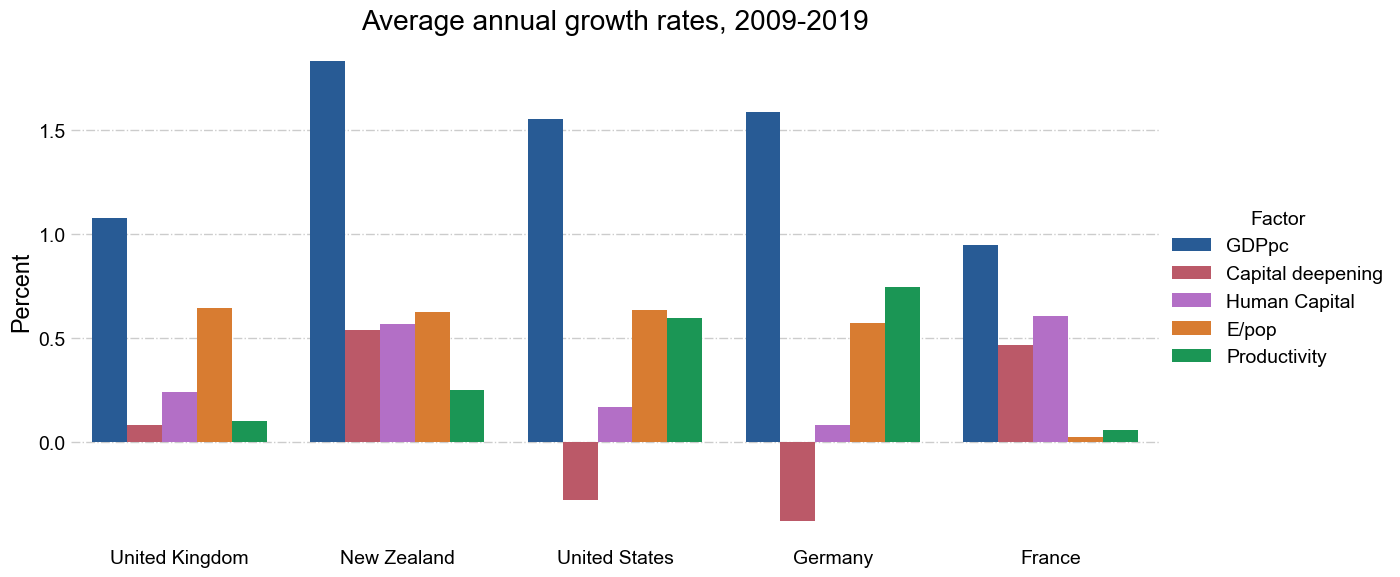

In [20]:
# plot the data
g = sns.catplot(x='Country', y="Growth rate", hue="Factor", 
                data=df_growth_1[df_growth_1.Period=='2009-2019'].loc[country_list_1],
                height=6, aspect=2,kind="bar")
g.despine(left=True,bottom=True)
g.set_ylabels("Percent")
g.set_xlabels("")
plt.title('Average annual growth rates, 2009-2019');

The above two graphs help us to see the growth rates of different factors in each country. We want to compare growth rates of factors in a country, the style in the above two graphs are more helpful.

Find the percentage contribution of each factor to GDP per capita growth in the listed countries during the two time periods. Fill in the tables below. Briefly comment on your results.

Because $g_{\frac{Y}{N}}= \frac{1}{1-\alpha}g_A+\frac{\alpha}{1-\alpha}g_{\frac{K}{Y}} + g_h + g_{\frac{L}{N}}$, the percentage contribution of
- human capital to GDP per capita growth is equal to $100 \frac{g_h}{g_{Y/N}}$

- total hours worked/population to GDP per capita growth is equal to $100 \frac{g_{L/N}}{g_{Y/N}}$

- physical capital/output(GDP) to GDP per capita growth is equal to $100 \frac{\alpha}{1-\alpha} \frac{g_{K/Y}}{g_{Y/N}}$

- productivity to GDP per capita growth is equal to $100 \frac{1}{1-\alpha} \frac{g_{A}}{g_{Y/N}}.$


In [21]:
# Now, specify the weights for each factor's contribution to GDP per capita growth
weights = dict(zip(vars_+['Productivity'],[1,alpha/(1-alpha),1,1,1/(1-alpha)]))

In [22]:
# Calculate percentage contributions of each factor
for var_ in vars_[1:]+['Productivity']:
    df_growth[f'con_{var_}'] = 100*df_growth[var_]*weights[var_]/df_growth['gdppc']

# Select only variables we need    
df_cont = df_growth[[var_ for var_ in df_growth.columns if ('con_' in var_) | (var_ in ['country','Period'])]]

# rename columns
df_cont.columns = ['Country','Period','Capital deepening','Human capital','E/pop','Productivity']

In [23]:
# Here are the results
df_cont.loc[country_list_1].round(decimals=2)

,Country,Period,Capital deepening,Human capital,E/pop,Productivity
countrycode,,,,,,
GBR,United Kingdom,1970-2008,15.07,35.20,-5.83,55.56
GBR,United Kingdom,2009-2019,3.71,22.47,59.88,13.94
NZL,New Zealand,1970-2008,60.79,10.06,20.05,9.10
NZL,New Zealand,2009-2019,14.62,31.01,33.98,20.38
USA,United States,1970-2008,12.73,23.59,13.60,50.07
USA,United States,2009-2019,-8.93,10.80,40.80,57.32
DEU,Germany,1970-2008,27.90,28.42,-36.45,80.14
DEU,Germany,2009-2019,-11.99,5.31,36.04,70.64
FRA,France,1970-2008,25.88,36.70,-31.11,68.52


In [24]:
# Convert the table into long-form (easier to plot graphs)
df_cont=df_cont.reset_index().melt(id_vars=['countrycode','Country','Period'],value_vars=df_cont.columns[2:],
             var_name='Factor',value_name='Contribution').set_index('countrycode')

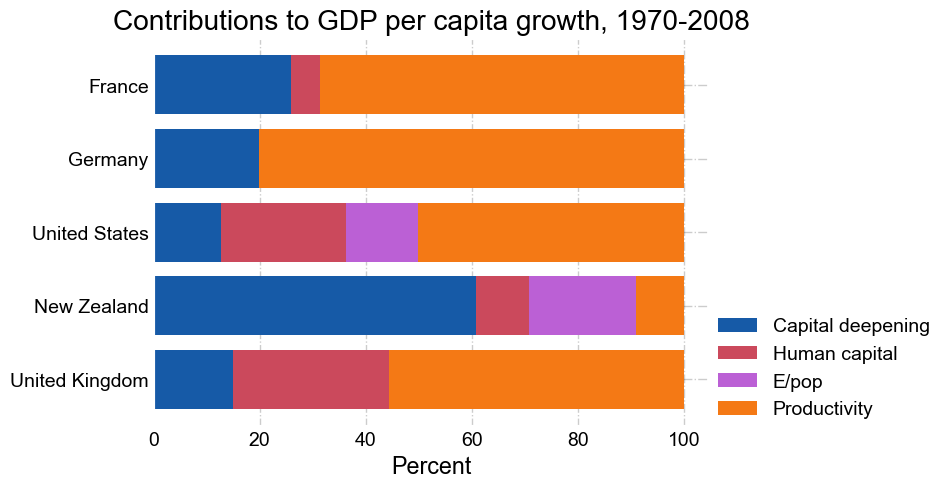

In [25]:
left_ = np.zeros(5)
period = period = df_cont.Period.unique()[0]
for factor in df_cont.Factor.unique():
    select = ((df_cont.Factor == factor)&(df_cont.Period == period))
    data = df_cont[select].loc[country_list_1].copy()
    plt.barh(np.arange(5),data['Contribution'],left=left_,label=factor)
    left_ +=  data['Contribution']
plt.yticks(np.arange(5),data.Country.values);
plt.xlabel('Percent')
plt.legend(loc=(1,0),frameon=False)
plt.title(f'Contributions to GDP per capita growth, {period}');

We observe that during 1970-2008, productivity growth is the biggest contributor to the economic growht in many countries except the New Zealand.

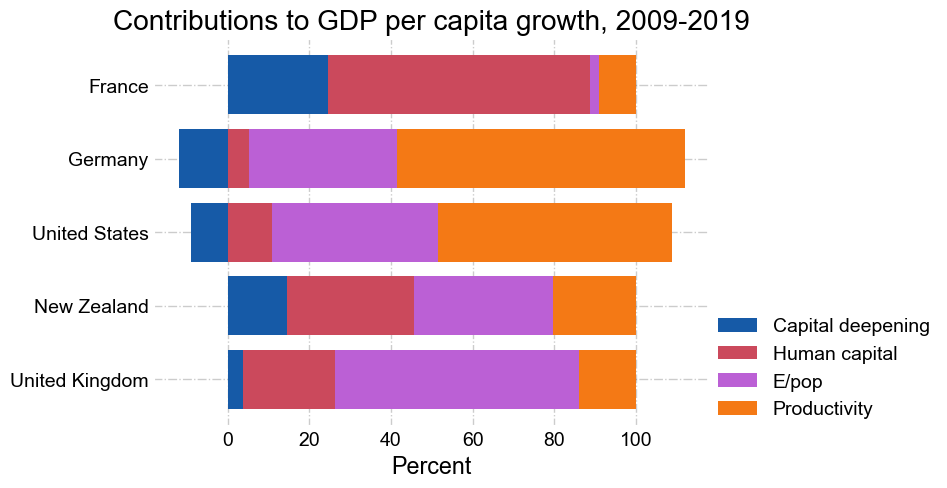

In [26]:
left_r = np.zeros(5)
left_l = np.zeros(5)
period = period = df_cont.Period.unique()[1]
for factor in df_cont.Factor.unique():
    select = ((df_cont.Factor == factor)&(df_cont.Period == period))
    data = df_cont[select].loc[country_list_1].copy()
    left = [left_r[i] if data.iloc[i]['Contribution'] >= 0 else left_l[i] for i in range(len(country_list_1))] 
    plt.barh(np.arange(5),data['Contribution'],left=left,label=factor)
    for i in range(len(country_list_1)):
        if data.iloc[i]['Contribution']>= 0:
            left_r[i] += data.iloc[i]['Contribution']
        else:
            left_l[i] += data.iloc[i]['Contribution']
plt.yticks(np.arange(5),data.Country.values);
plt.legend(loc=(1,0),frameon=False)
plt.xlabel('Percent')
plt.title(f'Contributions to GDP per capita growth, {period}');

We observe that, during 2009-2019 the growth in total hours worked to population ratio played a bigger role in promoting economic growth than its role in the 1970-2008 period. During this time period, productivity growth played a small role in the UK, Zew Zealand and France.

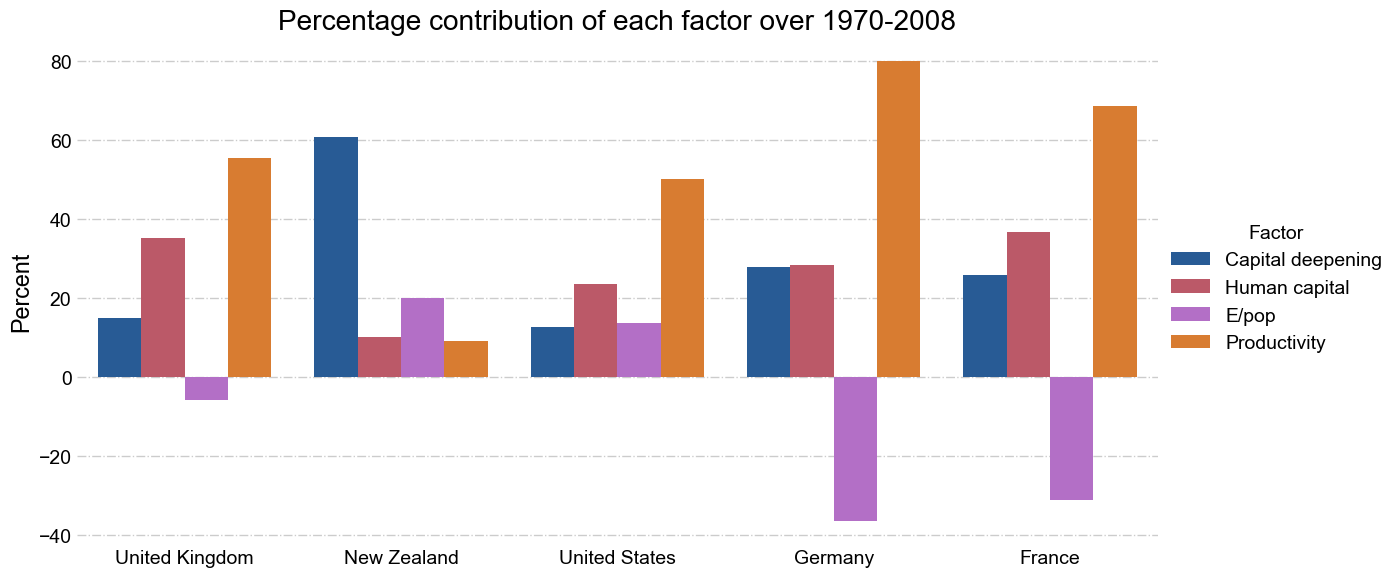

In [27]:
# plot the data
g = sns.catplot(x='Country', y="Contribution", hue="Factor", 
                data=df_cont[df_cont.Period=='1970-2008'].loc[country_list_1],
                height=6, aspect=2,kind="bar")
g.despine(left=True,bottom=True)
g.set_ylabels("Percent")
g.set_xlabels("")
plt.title('Percentage contribution of each factor over 1970-2008');

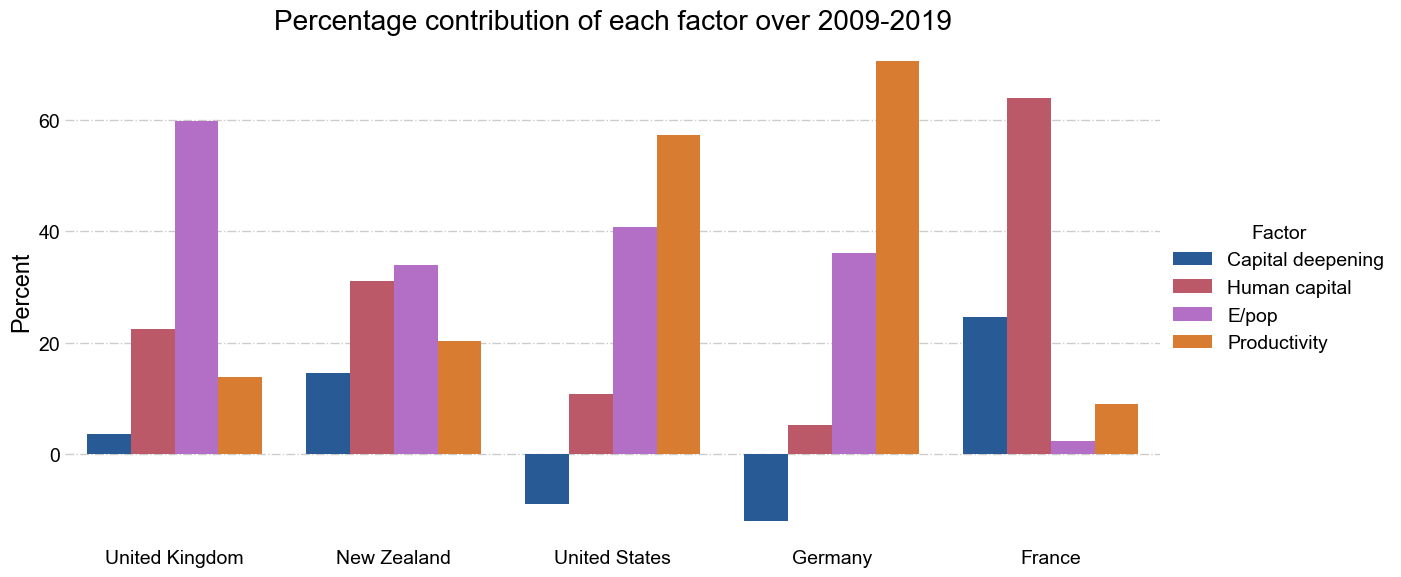

In [28]:
# plot the data
g = sns.catplot(x='Country', y="Contribution", hue="Factor", 
                data=df_cont[df_cont.Period=='2009-2019'].loc[country_list_1],
                height=6, aspect=2,kind="bar")
g.despine(left=True,bottom=True)
g.set_ylabels("Percent")
g.set_xlabels("")
plt.title('Percentage contribution of each factor over 2009-2019');

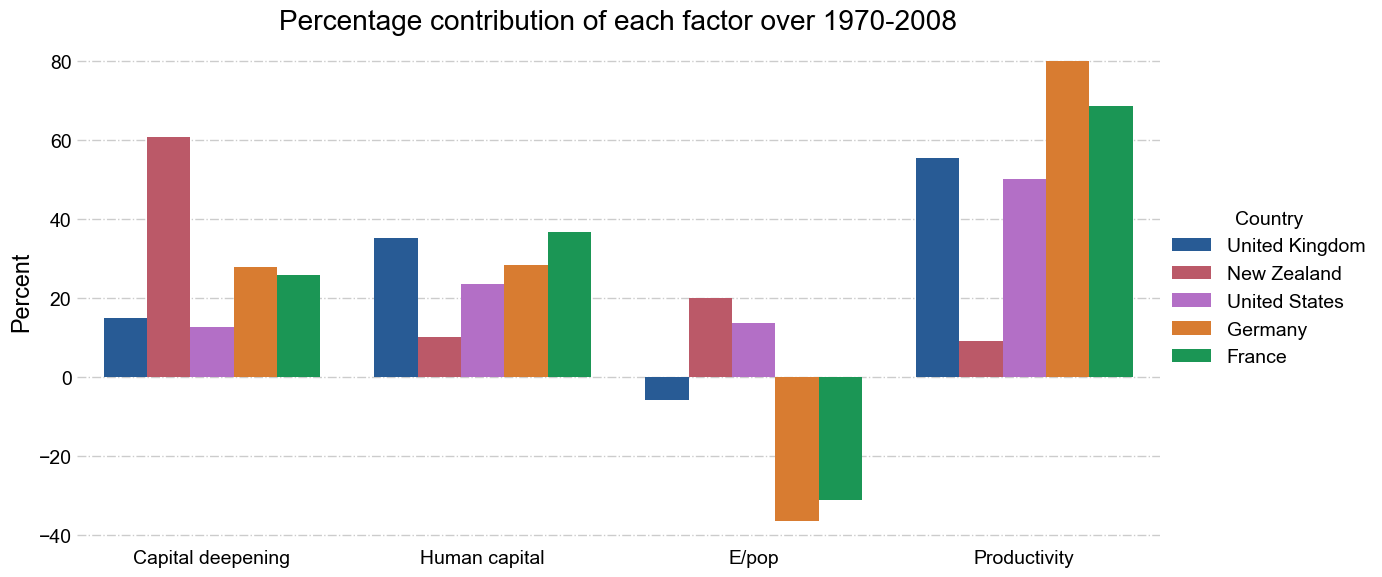

In [29]:
# plot the data
g = sns.catplot(hue='Country', y="Contribution", x="Factor", 
                data=df_cont[df_cont.Period=='1970-2008'].loc[country_list_1],
                height=6, aspect=2,kind="bar")
g.despine(left=True,bottom=True)
g.set_ylabels("Percent")
g.set_xlabels("")
plt.title('Percentage contribution of each factor over 1970-2008');

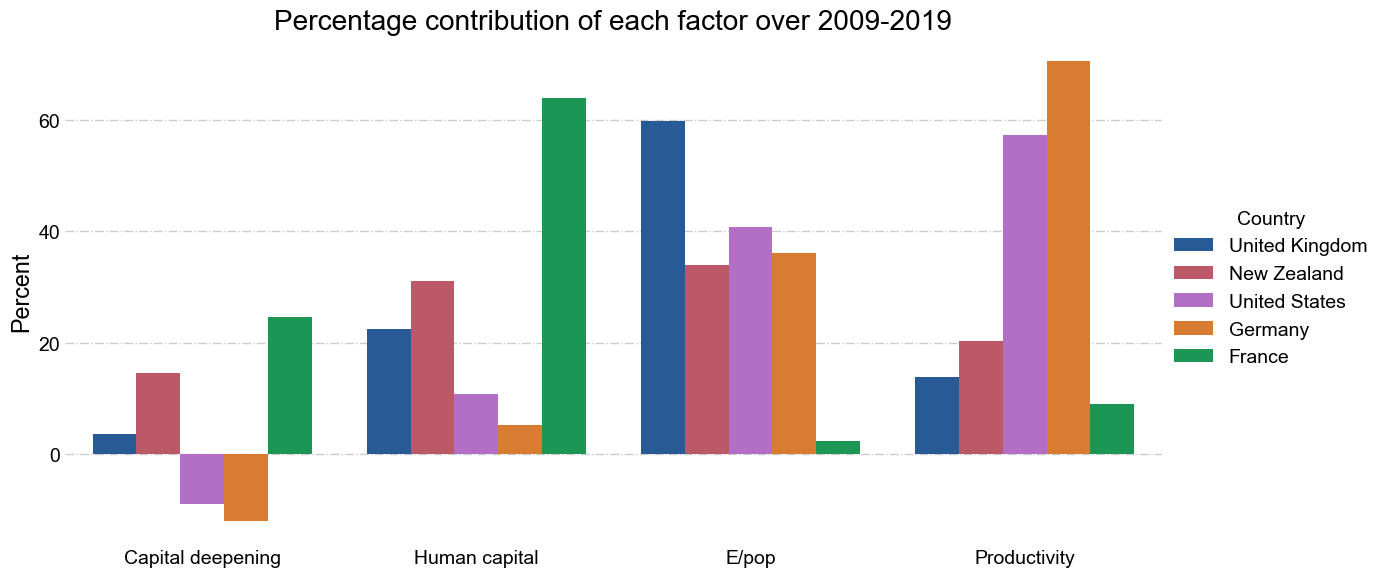

In [30]:
# plot the data
g = sns.catplot(hue='Country', y="Contribution", x="Factor", 
                data=df_cont[df_cont.Period=='2009-2019'].loc[country_list_1],
                height=6, aspect=2,kind="bar")
g.despine(left=True,bottom=True)
g.set_ylabels("Percent")
g.set_xlabels("")
plt.title('Percentage contribution of each factor over 2009-2019');